In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, precision_recall_curve, roc_curve, confusion_matrix, ConfusionMatrixDisplay, auc
from scipy.sparse import lil_matrix, csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Load the data with headers
train_data = pd.read_csv('activity_train.csv', header=None, names=['protein_id', 'molecule_id', 'activity'])
blanked_data = pd.read_csv('activity_test_blanked.csv', header=None, names=['protein_id', 'molecule_id'])

# Load the molecular fingerprints
pickle_data = pickle.load(open("mol_bits.pkl", "rb")) # pickle_data = pickle.load(f)

# Function to convert indices to sparse binary vector
def sparse_vector(indices, length):
    bitvector = lil_matrix((1, length), dtype=int)
    bitvector[0, indices] = 1
    return bitvector

# Determine the length of the bit vector
max_index = max([max(indices) for indices in pickle_data.values() if indices])  # Handle empty lists
vector_len = max_index + 1  # Length of bit vector

# Convert the fingerprint lists to sparse binary vectors
vectors = {k: sparse_vector(v, vector_len) for k, v in pickle_data.items()}

# Use column names directly
train_data['fingerprint'] = train_data['molecule_id'].apply(lambda x: vectors.get(x, lil_matrix((1, vector_len))))
blanked_data['fingerprint'] = blanked_data['molecule_id'].apply(lambda x: vectors.get(x, lil_matrix((1, vector_len))))

# Stack sparse matrices
X_sparse = lil_matrix((len(train_data), vector_len))
for i, vec in enumerate(train_data['fingerprint']):
    X_sparse[i, :] = vec

# Convert to CSR format for efficient arithmetic and matrix vector operations
X_sparse = X_sparse.tocsr()

# Extract labels for training data
y = train_data['activity']

print("done")

done


### SVD route

C:\Users\tntma\anaconda3\Lib\site-packages\sklearn\decomposition\_truncated_svd.py:273: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = exp_var / full_var


Validation Accuracy: 0.22027778801164205
Confusion Matrix:
 [[5979    0    0    0    0    0    0    0    0    0]
 [1862    0    0    0    0    0    0    0    0    0]
 [2712    0    0    0    0    0    0    0    0    0]
 [2729    0    0    0    0    0    0    0    0    0]
 [2979    0    0    0    0    0    0    0    0    0]
 [2800    0    0    0    0    0    0    0    0    0]
 [2687    0    0    0    0    0    0    0    0    0]
 [2129    0    0    0    0    0    0    0    0    0]
 [1426    0    0    0    0    0    0    0    0    0]
 [1840    0    0    0    0    0    0    0    0    0]]
Mean Squared Error (Validation): 21.97
R² Score (Validation): -1.65


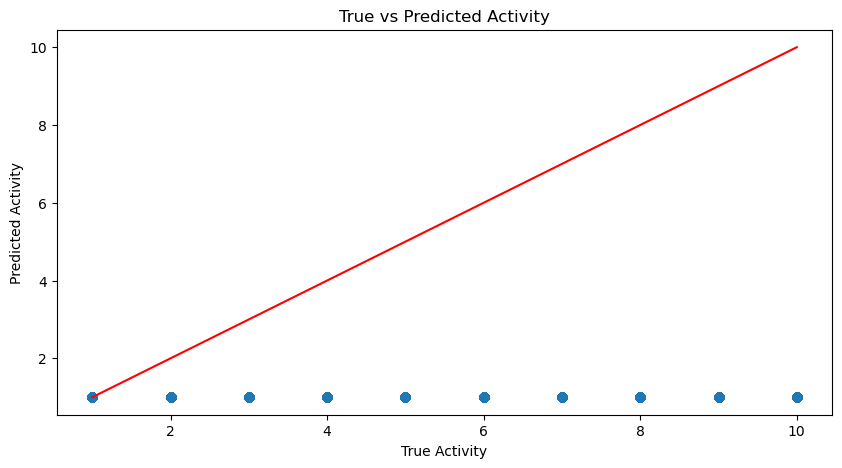

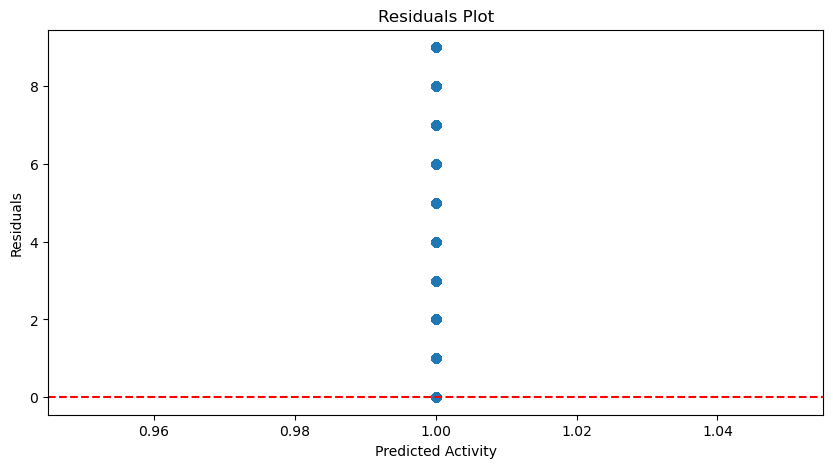

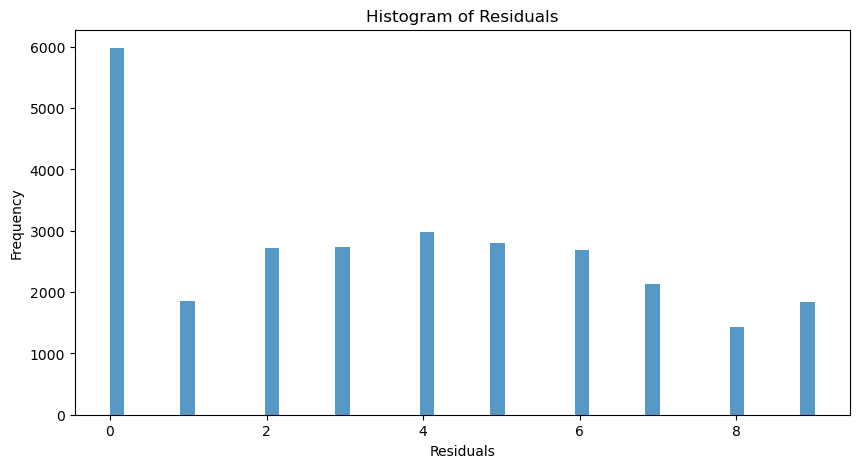

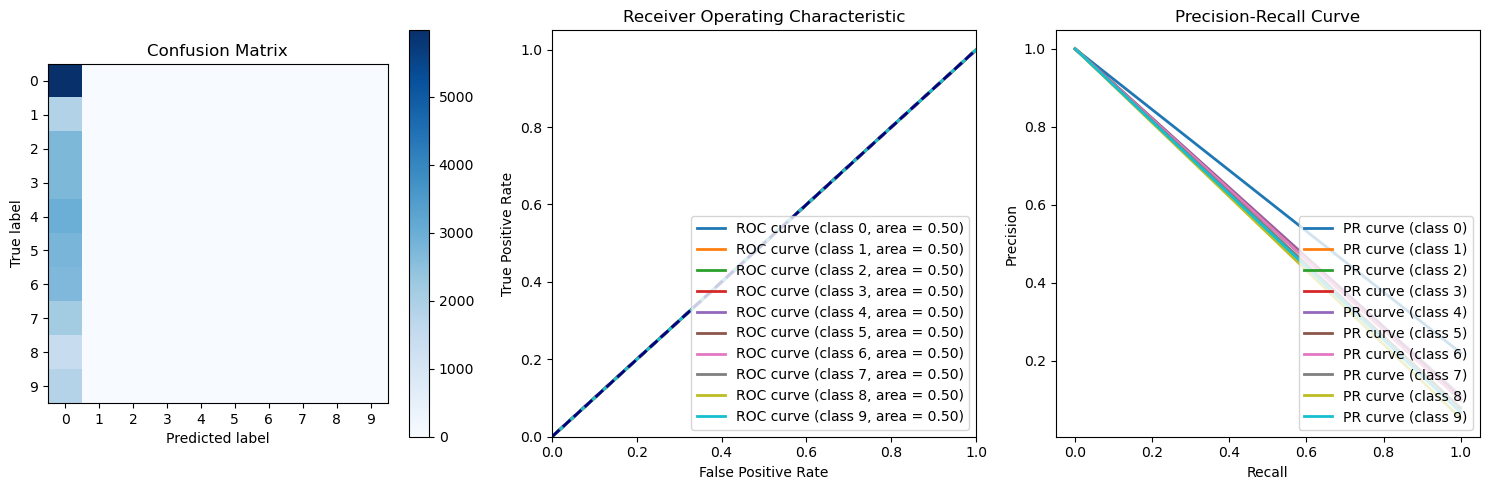

            protein_id  molecule_id  predicted_activity
O14842   CHEMBL2022258            0                   1
O14842   CHEMBL2047161            0                   1
O14842   CHEMBL2047163            0                   1
O14842   CHEMBL2047168            0                   1
O14842   CHEMBL2047169            0                   1
O14842   CHEMBL2048621            0                   1
O14842   CHEMBL2048623            0                   1
O14842    CHEMBL207881            0                   1
O14842   CHEMBL4067052            0                   1
O14842   CHEMBL4069191            0                   1


In [4]:
#### SVD ROUTE ####
from sklearn.metrics import mean_squared_error, r2_score, precision_recall_curve, roc_curve, confusion_matrix, ConfusionMatrixDisplay, auc

# Apply TruncatedSVD for dimensionality reduction
n_components = 100  # Number of components to keep
svd = TruncatedSVD(n_components=n_components)
X_reduced = svd.fit_transform(X_sparse)

# Split the data for training and validation
X_train, X_val, y_train, y_val = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# Binarize the labels for multi-class PR curve
y_bin = label_binarize(y_val, classes=np.unique(y))
n_classes = y_bin.shape[1]

# Train a One-vs-Rest Random Forest model
model = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
model.fit(X_train, y_train)

# Validate the model
y_pred = model.predict(X_val)
print('Validation Accuracy:', accuracy_score(y_val, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred)
print('Confusion Matrix:\n', conf_matrix)

# Calculate metrics
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"Mean Squared Error (Validation): {mse:.2f}")
print(f"R² Score (Validation): {r2:.2f}")

# Visualization of Results
# True vs Predicted Activity
plt.figure(figsize=(10, 5))
plt.scatter(y_val, y_pred, alpha=0.5)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red')
plt.xlabel('True Activity')
plt.ylabel('Predicted Activity')
plt.title('True vs Predicted Activity')
plt.show()

# Residuals Plot
residuals = y_val - y_pred
plt.figure(figsize=(10, 5))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Activity')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

# Histogram of Residuals
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=50, alpha=0.75)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

# ROC Curve
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], model.predict_proba(X_val)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Precision-Recall Curve
precision = dict()
recall = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_bin[:, i], model.predict_proba(X_val)[:, i])

# Plot Confusion Matrix
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(conf_matrix))
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Plot ROC Curves
plt.subplot(1, 3, 2)
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (class %d, area = %0.2f)' % (i, roc_auc[i]))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Plot Precision-Recall Curves
plt.subplot(1, 3, 3)
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label='PR curve (class %d)' % i)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

# Extract test features
X_test_sparse = lil_matrix((len(blanked_data), vector_len))
for i, vec in enumerate(blanked_data['fingerprint']):
    X_test_sparse[i, :] = vec

# Reduce the dimensionality of the test set
X_test_sparse = X_test_sparse.tocsr()
X_test_reduced = svd.transform(X_test_sparse)

# Predict the activity for the test set
blanked_data['predicted_activity'] = model.predict(X_test_reduced)

# Save the predictions to a new CSV file
# blanked_data.to_csv('activity_predictions.csv', index=False)

# Display the predictions in a readable format
predictions_df = blanked_data[['protein_id', 'molecule_id', 'predicted_activity']]
print(predictions_df.head(10))